In [1]:
import numpy as np
from model import *
import tensorflow as tf
import setGPU
from skimage import color
#strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"])

imgs = np.load('../dataset/cv/train/x/imgs_grayscale.npz')['arr_0']
labels = np.load('../dataset/cv/train/y/labels.npy')

setGPU: Setting GPU to: 1


In [2]:
characters = set(char for label in labels for char in label)

In [3]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
                  vocabulary=sorted(list(characters)), num_oov_indices=0, mask_token=None )

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
                  vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True )

In [4]:
imgs = np.transpose(imgs, (0, 2, 1, 3))
'''
max_len = max([len(label) for label in labels])
encoded_labels = []
for label in labels:
    if label:
        tmp = np.array([char_to_num(char) for char in label])
        encoded_labels.append(np.pad(tmp, (0, max_len-tmp.shape[0]), constant_values=0))
    else:
        tmp = np.array([char_to_num('#')])
        encoded_labels.append(np.pad(tmp, (0, max_len-tmp.shape[0]), constant_values=0))
'''

encoded_labels = np.load('../dataset/cv/train/y/encoded_labels.npy')

In [5]:
#Si inserisce alla fine di ogni array label la lunghezza reale della parola
t_dist_dim = int(128)          # Questo valore indica quanti step temporali ci sono: nelle ultime feature map ci sono 128/4
                                 # step temporali perché 128 è la larghezza massima tra le immagini in ingresso e 4 è il fattore
                                 # di riduzione dovuto ai MaxPooling (ci sono 2 livelli di MaxPooling che dimezzano le dimensioni)
enc2 = []
for i in range(encoded_labels.shape[0]):
    if len(labels[i]) == 0:
        enc2.append(np.append(encoded_labels[i], [1, t_dist_dim]))
    else:
        enc2.append(np.append(encoded_labels[i], [len(labels[i]), t_dist_dim]))
enc2 = np.array(enc2)

In [6]:
#with strategy.scope():
net = build_and_compile_model_v7(input_shape=(128, 128, 1), len_characters=len(characters), opt="Adam")

In [7]:
net.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         activation[0][0]                 
_______________________________________________________________________________________

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Early_Stopping_Patience = 10 
Min_Delta = 0.0001
# Model Check Point
Check_Point = ModelCheckpoint( 'weights/CRNN_v7_grayscale.h5',   # Filepath
                               monitor='val_loss',
                               save_best_only=True,
                               verbose=1,
                               mode='auto',
                               save_weights_only=False,
                               save_freq='epoch' )
# Add early stopping
Early_Stopping = EarlyStopping( monitor='val_loss',
                                min_delta=Min_Delta,
                                patience=Early_Stopping_Patience,
                                verbose=1,
                                mode='auto',
                                baseline=None,
                                restore_best_weights=True )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=0.0002)

In [9]:
batch_size = 64
x_train = imgs
y_train = enc2

In [10]:
history = net.fit(x_train, y_train, validation_split=0.2, epochs=100, callbacks=[Check_Point, reduce_lr], batch_size=batch_size)

Epoch 1/100
453/453 [==============================] - ETA: 0s - loss: 27.0543
Epoch 00001: val_loss improved from inf to 24.24805, saving model to weights/CRNN_v7_grayscale.h5
453/453 [==============================] - 312s 688ms/step - loss: 27.0543 - val_loss: 24.2481
Epoch 2/100
453/453 [==============================] - ETA: 0s - loss: 23.0358
Epoch 00002: val_loss improved from 24.24805 to 23.23459, saving model to weights/CRNN_v7_grayscale.h5
453/453 [==============================] - 308s 680ms/step - loss: 23.0358 - val_loss: 23.2346
Epoch 3/100
453/453 [==============================] - ETA: 0s - loss: 22.3918
Epoch 00003: val_loss improved from 23.23459 to 22.43062, saving model to weights/CRNN_v7_grayscale.h5
453/453 [==============================] - 308s 681ms/step - loss: 22.3918 - val_loss: 22.4306
Epoch 4/100
453/453 [==============================] - ETA: 0s - loss: 21.9548
Epoch 00004: val_loss improved from 22.43062 to 22.13620, saving model to weights/CRNN_v7_grays

KeyboardInterrupt: 

In [11]:
np.save('history/my_history_v6.npy',history.history)

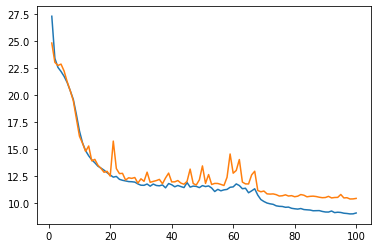

In [12]:
import matplotlib.pyplot as plt
plt.plot(range(1, 101), history.history['loss'])
plt.plot(range(1, 101), history.history['val_loss'])

In [11]:
!pip install trdg

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 91.2 MB 33 kB/s  eta 0:00:01
     |████████████████████████████████| 5.1 MB 48.0 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 7.3 MB/s  eta 0:00:01
anceled
ERROR: Operation cancelled by user
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


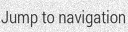

In [50]:
from trdg.generators import GeneratorFromRandom  
base_generator = GeneratorFromRandom(use_symbols=False, use_letters=True, length=1, width=128, size=32)
img, lbl = next(base_generator)
display(img)

In [52]:
np.array(img).shape

(32, 128, 3)

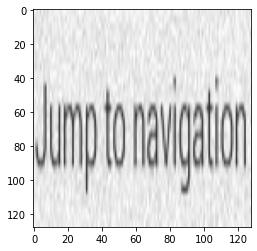

In [57]:
import matplotlib.pyplot as plt
plt.imshow(cv2.resize(np.array(img), (128, 128)))
plt.show()

In [38]:
import cv2
from skimage import color

In [ ]:
text = []
labels = []
for _ in range(5000):
    img, lbl = next(base_generator)
    img = cv2.resize(np.array(img), (128, 128))
    img = color.rgb2gray(img)
    text.append(img)
    labels.append(lbl)